### Load libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt

In [17]:
train_dir='ISBI2016_ISIC_Part3_Training_Data/'
train=pd.read_csv('ISBI2016_ISIC_Part3_Training_GroundTruth.csv')

In [18]:
train.head()

,image_name,benign_malignant,target
0,ISIC_0000000,benign,0
1,ISIC_0000001,benign,0
2,ISIC_0000002,malignant,1
3,ISIC_0000004,malignant,1
4,ISIC_0000006,benign,0


### Add image path to the training dataset itself

In [19]:
train['path'] = train_dir + train.image_name + ".jpg"
train.head()

,image_name,benign_malignant,target,path
0,ISIC_0000000,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000...
1,ISIC_0000001,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000001...
2,ISIC_0000002,malignant,1,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000002...
3,ISIC_0000004,malignant,1,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000004...
4,ISIC_0000006,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000006...


### Let's load a sample image

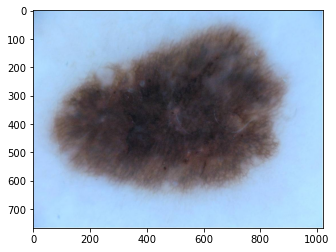

In [20]:
img=cv2.imread('ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg')   
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Class Distribution

In [21]:
train.target.value_counts()

0    727
1    173
Name: target, dtype: int64

We will take 600 images from for target = 0 and will take all 584 = 1184 images for target = 1
so, we will have total of 600 + 584 images in total to train our model.

This number is obviously not enough to train a image classification model, but since this is just a demo, we will take a small number of images to train the model quickly.

In [22]:
df_0=train[train['target']==0].sample(600)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

In [23]:
train.shape

(773, 5)

In [24]:
train.head()

,index,image_name,benign_malignant,target,path
0,211,ISIC_0000329,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000329...
1,869,ISIC_0011341,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0011341...
2,321,ISIC_0000507,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0000507...
3,409,ISIC_0002806,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0002806...
4,846,ISIC_0011230,benign,0,ISBI2016_ISIC_Part3_Training_Data/ISIC_0011230...


In [25]:
# we will resize the given images to 128 x 128 size images for faster processing
IMG_DIM = (128, 128)

In [26]:
# Keras provides some amazing libraries to work with images, lets import them
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [27]:
# We will reserve 20% of our training data for the validation purpose
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train.target, test_size=0.2, random_state=42)

In [28]:
# save image path
train_files = X_train.path
val_files = X_val.path

# load images using load_img function from keras preprocessing 
# target_size is used to load the images with smaller size
# img_to_array will tranform the loaded image to an array
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in val_files]

# convert the list of arrays to array
train_imgs = np.array(train_imgs)
train_labels = y_train

validation_imgs = np.array(validation_imgs)
val_labels = y_val


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (618, 128, 128, 3) 	Validation dataset shape: (155, 128, 128, 3)


### Scale Images
scale each image with pixel values between (0, 255) to values between (0, 1) because deep learning models work really well with small input values.

(128, 128, 3)


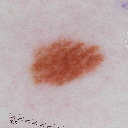

In [29]:
train_imgs_scaled = train_imgs.astype('float32')

validation_imgs_scaled  = validation_imgs.astype('float32')

# divide the pixels by 255 to scale the pixels between 0 and 1
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)

# array_to_img function will convert the given array to image
array_to_img(train_imgs[0])

We will use a batch_size of 30 and our training data has a total of 947 samples, which indicates that there will be a total of 947/30 = 32(approx) iterations per epoch. 

We train the model for a total of 30 epochs and validate it consequently on our validation set of 237 images.

In [30]:
# setup basic configuration
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (128, 128, 3)

### CNN Architecture and Parameters

We will start by building a basic CNN model with three convolutional layers, coupled with max pooling for auto-extraction of features from our images and also downsampling the output convolution feature maps.

In [32]:
# Here we will import the necessary libraries
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# we will import sequential model and add different layers to it
from keras.models import Sequential

# import optimizers, please go through online tutorials if you want to learn what is the purpose of an optimizer
#from keras import optimizers
from tensorflow.keras import optimizers

# creating and instance of Sequential
model = Sequential()

# add Conv2D layer(this is the convolutional layer we discussed earlier),filter size,kernel size,activation and padding are the parameters used
# This layer would create feature maps for each and every filter used
# feature maps created here are then taken through an activation function(relu here), which decides whether a certain feature is present 
# at a given location in the image.
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
# Pooling layer used here will select the largest values on the feature maps and use these as inputs to subsequent layers
model.add(MaxPooling2D(pool_size=(2, 2)))


# another set of Convolutional & Max Pooling layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# Finally the Dense Layer
model.add(Dense(512, activation='relu'))
# sigmoid function here will help us in perform binary classification
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [33]:
history = model.fit(x=train_imgs_scaled, y=train_labels,
                    validation_data=(validation_imgs_scaled, val_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
21/21 [==============================] - 7s 320ms/step - loss: 0.6943 - accuracy: 0.7460 - val_loss: 0.6797 - val_accuracy: 0.7484
Epoch 2/30
21/21 [==============================] - 6s 281ms/step - loss: 0.5356 - accuracy: 0.7848 - val_loss: 0.5721 - val_accuracy: 0.7484
Epoch 3/30
21/21 [==============================] - 6s 273ms/step - loss: 0.5292 - accuracy: 0.7880 - val_loss: 0.5520 - val_accuracy: 0.7419
Epoch 4/30
21/21 [==============================] - 6s 270ms/step - loss: 0.5318 - accuracy: 0.7751 - val_loss: 0.5605 - val_accuracy: 0.7419
Epoch 5/30
21/21 [==============================] - 6s 269ms/step - loss: 0.4917 - accuracy: 0.7896 - val_loss: 0.5406 - val_accuracy: 0.7290
Epoch 6/30
21/21 [==============================] - 6s 269ms/step - loss: 0.4861 - accuracy: 0.7994 - val_loss: 0.5357 - val_accuracy: 0.7355
Epoch 7/30
21/21 [==============================] - 6s 274ms/step - loss: 0.4613 - accuracy: 0.7994 - val_loss: 0.5204 - val_accuracy: 0.7484
Epoch 

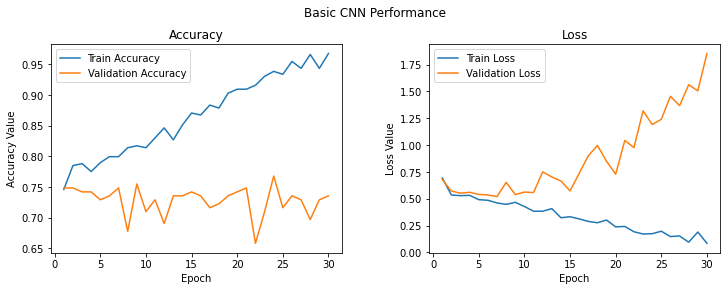

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")